In [1]:
import sys
sys.path.append('../../pyutils')

import matplotlib.pyplot as plt
import numpy as np
import torch

import metrics
import utils

Autoencoders are neural network that perform non-linear dimensionality reduction.  
It's a multilayer neural network with a small central layer, that learns the identity function. This central layer is the learned representation.  

The first part, transforming the data to the central layer representation, is called the encoder, and the second part, reconstructing the data from the central layer representation, is called the decoder.

Epoch 1: Loss = 1865.35546875
Epoch 2: Loss = 1735.2796630859375
Epoch 3: Loss = 1670.501953125
Epoch 4: Loss = 1634.2183837890625
Epoch 5: Loss = 1613.341064453125
Epoch 6: Loss = 1585.9656982421875
Epoch 7: Loss = 1579.418701171875
Epoch 8: Loss = 1561.5101318359375
Epoch 9: Loss = 1549.8514404296875
Epoch 10: Loss = 1532.70361328125
Epoch 11: Loss = 1530.68359375
Epoch 12: Loss = 1519.9959716796875
Epoch 13: Loss = 1521.6212158203125
Epoch 14: Loss = 1506.0830078125
Epoch 15: Loss = 1498.396240234375
Epoch 16: Loss = 1495.1683349609375
Epoch 17: Loss = 1490.6741943359375
Epoch 18: Loss = 1488.89404296875
Epoch 19: Loss = 1478.619873046875
Epoch 20: Loss = 1478.5787353515625
Epoch 21: Loss = 1477.886962890625
Epoch 22: Loss = 1479.095947265625
Epoch 23: Loss = 1471.9012451171875
Epoch 24: Loss = 1471.8179931640625
Epoch 25: Loss = 1471.7353515625


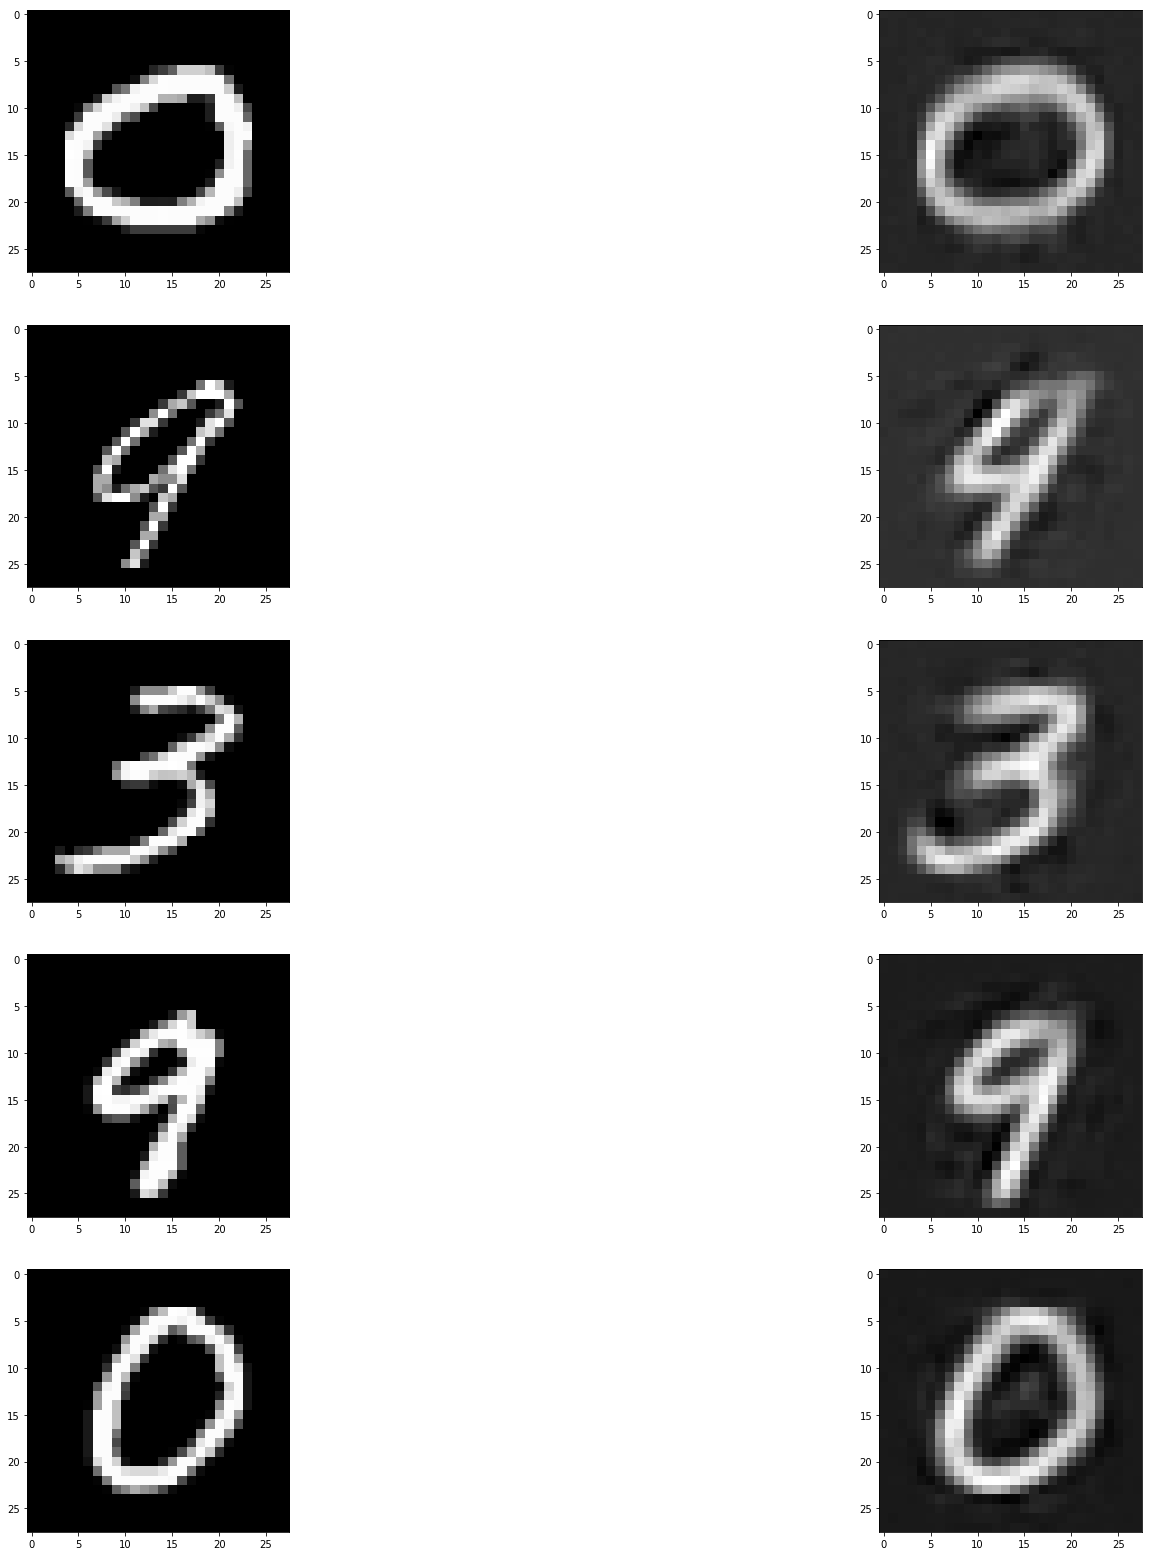

In [2]:
from sklearn.datasets import load_digits

IN_SIZE = 28 * 28
HIDDEN1_SIZE = 500
OUT_SIZE = 10

NEPOCHS = 25
LR = 1e-3
BATCH_SIZE = 64

X, y, X_test, y_test = utils.load_mnist_np('/tmp/data')
X = X.reshape(len(X), -1)
#X = X.astype(np.float32)

class Net(torch.nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.el1 = torch.nn.Linear(IN_SIZE , HIDDEN1_SIZE)
        self.el2 = torch.nn.Linear(HIDDEN1_SIZE, OUT_SIZE)
        self.dl1 = torch.nn.Linear(OUT_SIZE, HIDDEN1_SIZE)
        self.dl2 = torch.nn.Linear(HIDDEN1_SIZE, IN_SIZE)
        
    def encoder(self, x):
        x = torch.relu(self.el1(x))
        x = torch.relu(self.el2(x))
        return x
    
    def decoder(self, x):
        x = torch.relu(self.dl1(x))
        x = self.dl2(x)
        return x

    def forward(self, x):
        return self.decoder(self.encoder(x))


net = Net()
criterion = torch.nn.MSELoss(reduction='mean')
opti = torch.optim.Adam(net.parameters(), lr=LR)

for epoch in range(NEPOCHS):
    
    p = np.random.permutation(len(X))
    X = X[p]
    for ki in range(0, len(X), BATCH_SIZE):
        tX = torch.from_numpy(X[ki:ki+BATCH_SIZE])

        net.zero_grad()
        Xr = net(tX)
        loss = criterion(Xr, tX)
        loss.backward()
        opti.step()
    
    if epoch % 1 == 0:
        tX = torch.from_numpy(X)
        Xr = net(tX)
        loss = criterion(Xr, tX)
        print('Epoch {}: Loss = {}'.format(epoch+1, loss.data))
        


fig=plt.figure(figsize=(28, 28))
for i in range(5):
    X0 = X[i]
    X0r = net(torch.from_numpy(X0)).data.numpy()
    fig.add_subplot(5, 2, 2*i+1)
    plt.imshow(X0.reshape(28, 28), cmap='gray')
    fig.add_subplot(5, 2, 2*i+2)
    plt.imshow(X0r.reshape(28, 28), cmap='gray')

plt.show()

With multiple layers, it's usually difficult to optimize if the weights are randomly initialized, gradient descent found a poor local minima.  
It works well when the initial weights are close to to a good solution.  

The weights are initialized with unsupervised learning, by trainining a deep belief network on the data.  
The weights obtained correspond to the weights of the encoder. The DBF is unfolded (symmetry) to also get the weights of the decoder.  
The whole networs is then trained usually, with the weights from the DBF.